In [ ]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


Part 1. Stock Return Data - Alpha Vantage

In [ ]:
!pip install alpha_vantage

In [ ]:
API_KEY_AV = '70XB7VA95KKG321V.'
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key=API_KEY_AV,output_format='pandas', indexing_type='date')


In [ ]:
stockReturnDict = {}
stockReturnDF = pd.DataFrame()
meta_data = {}
import time
tickerList = ['MSFT']
for ticker in tickerList:
  print(ticker)

  try:
    stockReturnDict[ticker], meta_data[ticker] = ts.get_daily_adjusted(symbol=ticker, outputsize= 'full')
    stockReturnDict[ticker].sort_values('date')
    stockReturnDict[ticker]['ticker'] = ticker
    
    stockReturnDF = pd.concat([stockReturnDF, stockReturnDict[ticker]], axis=0)
    stockReturnDF.head()
  except:
    pass
  time.sleep(1)  

MSFT


In [ ]:
stockReturnDict['MSFT']

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,ticker
date,,,,,,,,,
2021-11-01,331.355,331.4900,326.3700,329.37,329.370000,26840400.0,0.0,1.0,MSFT
2021-10-29,324.130,332.0000,323.9000,331.62,331.620000,34765982.0,0.0,1.0,MSFT
2021-10-28,324.325,324.8700,321.3601,324.35,324.350000,26297943.0,0.0,1.0,MSFT
2021-10-27,316.000,326.0973,316.0000,323.17,323.170000,52588690.0,0.0,1.0,MSFT
2021-10-26,311.000,312.3950,308.5967,310.11,310.110000,28107349.0,0.0,1.0,MSFT
...,...,...,...,...,...,...,...,...,...
1999-11-05,91.810,92.8700,90.5000,91.56,29.017782,35083700.0,0.0,1.0,MSFT
1999-11-04,92.310,92.7500,90.3100,91.75,29.077998,27119700.0,0.0,1.0,MSFT
1999-11-03,92.940,93.5000,91.5000,92.00,29.157229,22258500.0,0.0,1.0,MSFT


In [ ]:
stockReturnDF.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,ticker
date,,,,,,,,,
2021-11-01,331.355,331.4900,326.3700,329.37,329.37,26840400.0,0.0,1.0,MSFT
2021-10-29,324.130,332.0000,323.9000,331.62,331.62,34765982.0,0.0,1.0,MSFT
2021-10-28,324.325,324.8700,321.3601,324.35,324.35,26297943.0,0.0,1.0,MSFT
2021-10-27,316.000,326.0973,316.0000,323.17,323.17,52588690.0,0.0,1.0,MSFT
2021-10-26,311.000,312.3950,308.5967,310.11,310.11,28107349.0,0.0,1.0,MSFT


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

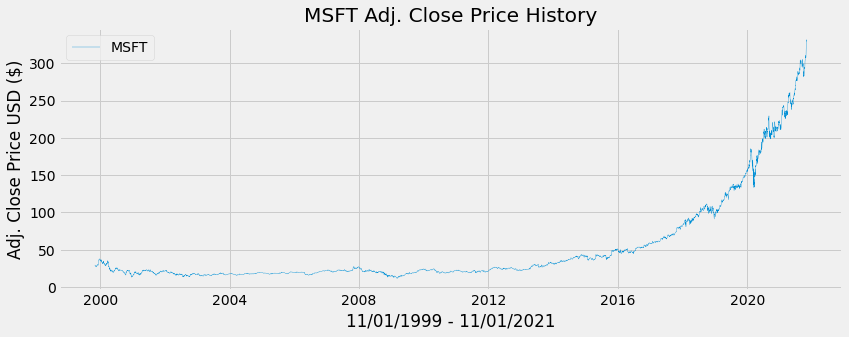

In [ ]:
ticker = 'MSFT'

start = min(stockReturnDict[ticker].index)
end = max(stockReturnDict[ticker].index)

plt.figure(figsize=(12.5, 4.5))
plt.plot(stockReturnDict[ticker]['5. adjusted close'], label = ticker, linewidth = 0.35)
plt.title(ticker+' Adj. Close Price History')
plt.xlabel(start.strftime("%m/%d/%Y")+" - "+end.strftime("%m/%d/%Y"))
plt.ylabel('Adj. Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [ ]:
stockReturnDF = stockReturnDF.sort_values(['ticker','date'])

In [ ]:
stockReturnDF['ret']  =  (stockReturnDF['5. adjusted close']-stockReturnDF['5. adjusted close'].shift(1))/stockReturnDF['5. adjusted close'].shift(1)
stockReturnDF['lnReturns']  = np.log(stockReturnDF['5. adjusted close']/stockReturnDF['5. adjusted close'].shift(1))

stockReturnDF.loc[stockReturnDF['ticker'] != stockReturnDF['ticker'].shift(1), 'lnReturns'] = np.NaN
stockReturnDF.loc[stockReturnDF['ticker'] != stockReturnDF['ticker'].shift(1), 'ret'] = np.NaN
  
stockReturnDF['date'] = stockReturnDF.index

In [ ]:
stockReturnDF.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,ticker,ret,lnReturns,date
date,,,,,,,,,,,,
1999-11-01,93.25,94.19,92.12,92.37,29.274492,26630600.0,0.0,1.0,MSFT,NaN,NaN,1999-11-01
1999-11-02,92.75,94.50,91.94,92.56,29.334708,23174500.0,0.0,1.0,MSFT,0.002057,0.002055,1999-11-02
1999-11-03,92.94,93.50,91.50,92.00,29.157229,22258500.0,0.0,1.0,MSFT,-0.006050,-0.006069,1999-11-03
1999-11-04,92.31,92.75,90.31,91.75,29.077998,27119700.0,0.0,1.0,MSFT,-0.002717,-0.002721,1999-11-04
1999-11-05,91.81,92.87,90.50,91.56,29.017782,35083700.0,0.0,1.0,MSFT,-0.002071,-0.002073,1999-11-05


Part 2. Fama French Factors

In [ ]:


# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
zipurl  = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip'

from urllib.request import urlopen
from zipfile import ZipFile

zipresp = urlopen(zipurl)
tempzip = open("/tmp/tempfile.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
    
zf = ZipFile("/tmp/tempfile.zip")
zf.extractall(path = '/tmp')
zf.close()



In [ ]:

ffDF = pd.read_csv("/tmp/F-F_Research_Data_Factors.CSV", skiprows=3)
ffDF.head()


,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.38,-2.73,0.22
1,192608,2.64,-1.47,4.14,0.25
2,192609,0.36,-1.39,0.12,0.23
3,192610,-3.24,-0.13,0.65,0.32
4,192611,2.53,-0.16,-0.38,0.31


In [ ]:
ffDF['YearMonth'] = ffDF['Unnamed: 0']
ffDF['MktRF'] = pd.to_numeric(ffDF['Mkt-RF'], errors='coerce')/100
ffDF['SMB'] = pd.to_numeric(ffDF['SMB'], errors='coerce')/100
ffDF['HML'] = pd.to_numeric(ffDF['HML'], errors='coerce')/100
ffDF['RF'] = pd.to_numeric(ffDF['RF'], errors='coerce')/100
ffDF.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF,YearMonth,MktRF
0,192607,2.96,-0.0238,-0.0273,0.0022,192607,0.0296
1,192608,2.64,-0.0147,0.0414,0.0025,192608,0.0264
2,192609,0.36,-0.0139,0.0012,0.0023,192609,0.0036
3,192610,-3.24,-0.0013,0.0065,0.0032,192610,-0.0324
4,192611,2.53,-0.0016,-0.0038,0.0031,192611,0.0253


Part 3. Creating Monthly returns

3-1. Creating Year-month in stockReturnDF


In [ ]:
stockReturnDF.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,ticker,ret,lnReturns,date
date,,,,,,,,,,,,
1999-11-01,93.25,94.19,92.12,92.37,29.274492,26630600.0,0.0,1.0,MSFT,NaN,NaN,1999-11-01
1999-11-02,92.75,94.50,91.94,92.56,29.334708,23174500.0,0.0,1.0,MSFT,0.002057,0.002055,1999-11-02
1999-11-03,92.94,93.50,91.50,92.00,29.157229,22258500.0,0.0,1.0,MSFT,-0.006050,-0.006069,1999-11-03
1999-11-04,92.31,92.75,90.31,91.75,29.077998,27119700.0,0.0,1.0,MSFT,-0.002717,-0.002721,1999-11-04
1999-11-05,91.81,92.87,90.50,91.56,29.017782,35083700.0,0.0,1.0,MSFT,-0.002071,-0.002073,1999-11-05


In [ ]:
stockReturnDF['YearMonth'] = stockReturnDF['date'].map(lambda x: str(x)[:4] + str(x)[5:7])

In [ ]:
stockReturnDF.head()


,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,ticker,ret,lnReturns,date,YearMonth
date,,,,,,,,,,,,,
1999-11-01,93.25,94.19,92.12,92.37,29.274492,26630600.0,0.0,1.0,MSFT,NaN,NaN,1999-11-01,199911
1999-11-02,92.75,94.50,91.94,92.56,29.334708,23174500.0,0.0,1.0,MSFT,0.002057,0.002055,1999-11-02,199911
1999-11-03,92.94,93.50,91.50,92.00,29.157229,22258500.0,0.0,1.0,MSFT,-0.006050,-0.006069,1999-11-03,199911
1999-11-04,92.31,92.75,90.31,91.75,29.077998,27119700.0,0.0,1.0,MSFT,-0.002717,-0.002721,1999-11-04,199911
1999-11-05,91.81,92.87,90.50,91.56,29.017782,35083700.0,0.0,1.0,MSFT,-0.002071,-0.002073,1999-11-05,199911


3-2. Create Monthly Returns

In [ ]:
monthlyStockReturns = stockReturnDF.groupby(['ticker', 'YearMonth'])['lnReturns'].sum()
monthlyStockReturns.head()

ticker  YearMonth
MSFT    199911      -0.014393
        199912       0.248626
        200001      -0.176395
        200002      -0.090855
        200003       0.173010
Name: lnReturns, dtype: float64

=============================================================================================================================================================================================

Part 4. Creating the Final Merged Dataset

4-1. Merge Monthly Stock Returns with FF


In [ ]:
monthlyStockReturnsDF  = monthlyStockReturns.to_frame()
monthlyStockReturnsDF['ticker'] = monthlyStockReturnsDF.index.get_level_values('ticker') 

In [ ]:
monthlyStockReturnsDF.head(12)

lnReturns ticker
ticker YearMonth                     
MSFT   199911    -1.439344e-02   MSFT
       199912     2.486261e-01   MSFT
       200001    -1.763948e-01   MSFT
       200002    -9.085501e-02   MSFT
       200003     1.730098e-01   MSFT
       200004    -4.208774e-01   MSFT
       200005    -1.087913e-01   MSFT
       200006     2.459005e-01   MSFT
       200007    -1.362494e-01   MSFT
       200008    -2.675811e-16   MSFT
       200009    -1.462793e-01   MSFT
       200010     1.327227e-01   MSFT

In [ ]:
mergedDf = monthlyStockReturnsDF.merge(ffDF, on='YearMonth')

In [ ]:
mergedDf.head()

,YearMonth,lnReturns,ticker,Unnamed: 0,Mkt-RF,SMB,HML,RF,MktRF
0,199911,-0.014393,MSFT,199911,3.37,0.0722,-0.0616,0.0036,0.0337
1,199912,0.248626,MSFT,199912,7.72,0.0699,-0.0832,0.0044,0.0772
2,200001,-0.176395,MSFT,200001,-4.74,0.0579,-0.0189,0.0041,-0.0474
3,200002,-0.090855,MSFT,200002,2.45,0.2148,-0.0981,0.0043,0.0245
4,200003,0.173010,MSFT,200003,5.20,-0.1729,0.0823,0.0047,0.0520


In [ ]:
mergedDf['YearMonthNumeric'] = pd.to_numeric(mergedDf['YearMonth'])

In [ ]:
mergedDf.head()

,YearMonth,lnReturns,ticker,Unnamed: 0,Mkt-RF,SMB,HML,RF,MktRF,YearMonthNumeric
0,199911,-0.014393,MSFT,199911,3.37,0.0722,-0.0616,0.0036,0.0337,199911
1,199912,0.248626,MSFT,199912,7.72,0.0699,-0.0832,0.0044,0.0772,199912
2,200001,-0.176395,MSFT,200001,-4.74,0.0579,-0.0189,0.0041,-0.0474,200001
3,200002,-0.090855,MSFT,200002,2.45,0.2148,-0.0981,0.0043,0.0245,200002
4,200003,0.173010,MSFT,200003,5.20,-0.1729,0.0823,0.0047,0.0520,200003


4-2. Backing Up data

In [ ]:
from google.colab import files

#stockReturnDict['MMM']

#stockReturnDF.to_csv("/tmp/stockReturnDf_20.csv")
#time.sleep(10)
#files.download("/tmp/stockReturnDf_20.csv")

#mergedDf.to_csv("/tmp/mergedDf_20.csv")
#time.sleep(10)
#files.download("/tmp/mergedDf_20.csv")
#stockReturnDF.head()


In [ ]:
#"""
from google.colab import files

#files.upload()
#files.upload()
 
#"""

In [ ]:

#data2 = pd.read_csv("stockReturnDf_21.csv")
#data2.head()
#stockReturnDF = data2

#data3 = pd.read_csv("mergedDf_21.csv")
#data3.head()
#mergedDf = data3

In [ ]:
stockReturnDF.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,ticker,ret,lnReturns,date,YearMonth
date,,,,,,,,,,,,,
1999-11-01,93.25,94.19,92.12,92.37,29.274492,26630600.0,0.0,1.0,MSFT,NaN,NaN,1999-11-01,199911
1999-11-02,92.75,94.50,91.94,92.56,29.334708,23174500.0,0.0,1.0,MSFT,0.002057,0.002055,1999-11-02,199911
1999-11-03,92.94,93.50,91.50,92.00,29.157229,22258500.0,0.0,1.0,MSFT,-0.006050,-0.006069,1999-11-03,199911
1999-11-04,92.31,92.75,90.31,91.75,29.077998,27119700.0,0.0,1.0,MSFT,-0.002717,-0.002721,1999-11-04,199911
1999-11-05,91.81,92.87,90.50,91.56,29.017782,35083700.0,0.0,1.0,MSFT,-0.002071,-0.002073,1999-11-05,199911


In [ ]:
mergedDf.head()

,YearMonth,lnReturns,ticker,Unnamed: 0,Mkt-RF,SMB,HML,RF,MktRF,YearMonthNumeric
0,199911,-0.014393,MSFT,199911,3.37,0.0722,-0.0616,0.0036,0.0337,199911
1,199912,0.248626,MSFT,199912,7.72,0.0699,-0.0832,0.0044,0.0772,199912
2,200001,-0.176395,MSFT,200001,-4.74,0.0579,-0.0189,0.0041,-0.0474,200001
3,200002,-0.090855,MSFT,200002,2.45,0.2148,-0.0981,0.0043,0.0245,200002
4,200003,0.173010,MSFT,200003,5.20,-0.1729,0.0823,0.0047,0.0520,200003


=============================================================================================================================================================================================


Par 5. Run CAPM regression

5-1. Basic Distribution Check
 

In [ ]:
mergedDf.isnull().values.any()

False

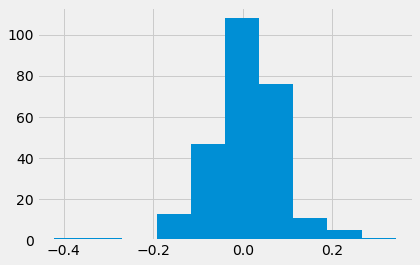

In [ ]:
mergedDf['lnReturns'].hist()

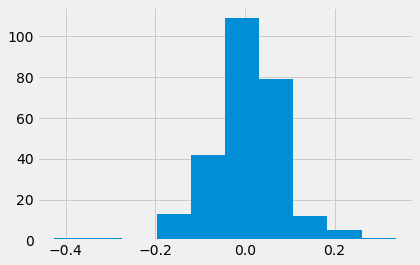

In [ ]:
mergedDf['lnReturnsRF'] = mergedDf['lnReturns']-mergedDf['RF']
mergedDf['lnReturnsRF'].hist()

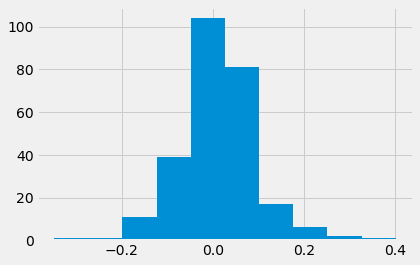

In [ ]:
mergedDf['RtRF'] = np.exp(mergedDf['lnReturns'])-1-mergedDf['RF']
mergedDf['RtRF'].hist()

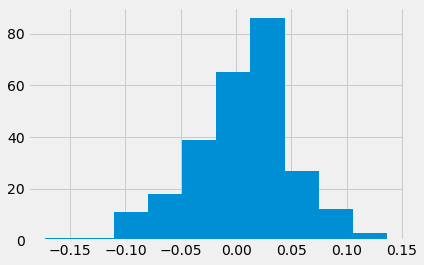

In [ ]:

mergedDf['MktRF'].hist()

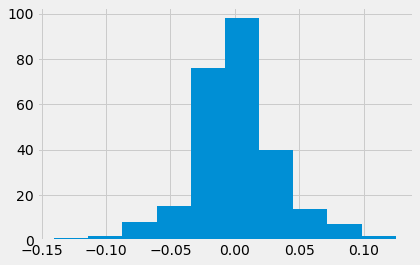

In [ ]:
mergedDf['HML'].hist()

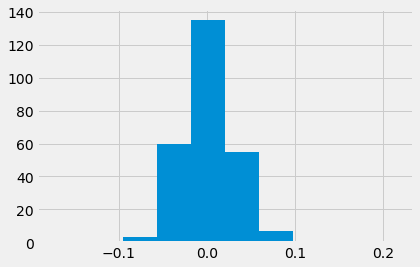

In [ ]:
mergedDf['SMB'].hist()

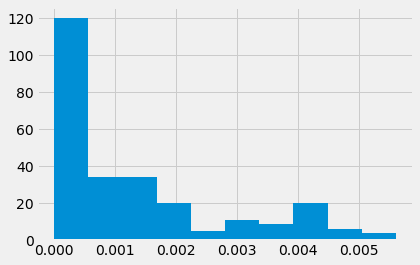

In [ ]:
mergedDf['RF'].hist()

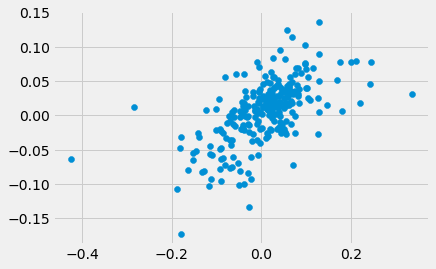

In [ ]:
 plt.scatter(mergedDf['lnReturnsRF'], mergedDf['MktRF'])

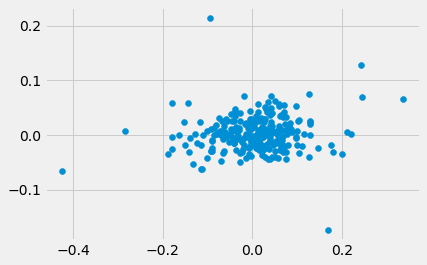

In [ ]:
 plt.scatter(mergedDf['lnReturnsRF'], mergedDf['SMB'])

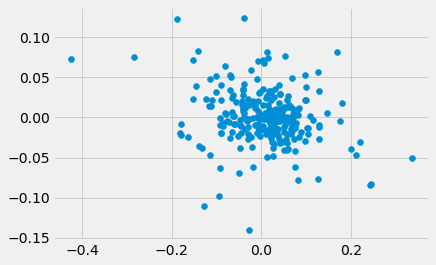

In [ ]:
 plt.scatter(mergedDf['lnReturnsRF'], mergedDf['HML'])

 - For 36 month rolling 
 - Remember to run regression for each ticker!


In [ ]:
 
mergedDf2_MSFT= mergedDf.loc[ (mergedDf['ticker'] =='MSFT')]
mergedDf2_MSFT_2021 = mergedDf.loc[(mergedDf['YearMonthNumeric'] >=201810) & (mergedDf['YearMonthNumeric'] <202110)& (mergedDf['ticker'] =='MSFT')]



In [ ]:
mergedDf2_MSFT

,YearMonth,lnReturns,ticker,Unnamed: 0,Mkt-RF,SMB,HML,RF,MktRF,YearMonthNumeric,lnReturnsRF,RtRF
0,199911,-0.014393,MSFT,199911,3.37,0.0722,-0.0616,0.0036,0.0337,199911,-0.017993,-0.017890
1,199912,0.248626,MSFT,199912,7.72,0.0699,-0.0832,0.0044,0.0772,199912,0.244226,0.277862
2,200001,-0.176395,MSFT,200001,-4.74,0.0579,-0.0189,0.0041,-0.0474,200001,-0.180495,-0.165813
3,200002,-0.090855,MSFT,200002,2.45,0.2148,-0.0981,0.0043,0.0245,200002,-0.095155,-0.091150
4,200003,0.173010,MSFT,200003,5.20,-0.1729,0.0823,0.0047,0.0520,200003,0.168310,0.184178
...,...,...,...,...,...,...,...,...,...,...,...,...
258,202105,-0.007662,MSFT,202105,0.29,-0.0028,0.0704,0.0000,0.0029,202105,-0.007662,-0.007633
259,202106,0.081570,MSFT,202106,2.75,0.0180,-0.0776,0.0000,0.0275,202106,0.081570,0.084989
260,202107,0.050424,MSFT,202107,1.27,-0.0396,-0.0175,0.0000,0.0127,202107,0.050424,0.051717
261,202108,0.059781,MSFT,202108,2.90,-0.0048,-0.0013,0.0000,0.0290,202108,0.059781,0.061604


In [ ]:
mergedDf2_MSFT_2021.rename(columns={'lnReturns':'const'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
mergedDf2_MSFT_2021

,YearMonth,const,ticker,Unnamed: 0,Mkt-RF,SMB,HML,RF,MktRF,YearMonthNumeric,lnReturnsRF,RtRF
227,201810,-0.068387,MSFT,201810,-7.68,-0.0482,0.0343,0.0019,-0.0768,201810,-0.070287,-0.068001
228,201811,0.041860,MSFT,201811,1.69,-0.0068,0.0026,0.0018,0.0169,201811,0.040060,0.040948
229,201812,-0.087791,MSFT,201812,-9.55,-0.0242,-0.0190,0.0019,-0.0955,201812,-0.089691,-0.085947
230,201901,0.027769,MSFT,201901,8.41,0.0290,-0.0044,0.0021,0.0841,201901,0.025669,0.026058
231,201902,0.074534,MSFT,201902,3.40,0.0204,-0.0268,0.0018,0.0340,201902,0.072734,0.075582
232,201903,0.051409,MSFT,201903,1.10,-0.0298,-0.0405,0.0019,0.0110,201903,0.049509,0.050854
233,201904,0.101963,MSFT,201904,3.96,-0.0174,0.0217,0.0021,0.0396,201904,0.099863,0.105243
234,201905,-0.050798,MSFT,201905,-6.94,-0.0134,-0.0237,0.0021,-0.0694,201905,-0.052898,-0.051629
235,201906,0.079844,MSFT,201906,6.93,0.0025,-0.0071,0.0018,0.0693,201906,0.078044,0.081318
236,201907,0.017097,MSFT,201907,1.19,-0.0194,0.0042,0.0019,0.0119,201907,0.015197,0.015344


In [ ]:
result=mergedDf2_MSFT_2021[['const','MktRF','SMB','HML']]

In [ ]:
df

,const,MktRF,SMB,HML
227,-0.068387,-0.0768,-0.0482,0.0343
228,0.041860,0.0169,-0.0068,0.0026
229,-0.087791,-0.0955,-0.0242,-0.0190
230,0.027769,0.0841,0.0290,-0.0044
231,0.074534,0.0340,0.0204,-0.0268
232,0.051409,0.0110,-0.0298,-0.0405
233,0.101963,0.0396,-0.0174,0.0217
234,-0.050798,-0.0694,-0.0134,-0.0237
235,0.079844,0.0693,0.0025,-0.0071
236,0.017097,0.0119,-0.0194,0.0042


In [ ]:
df.to_csv('HW.csv',index=True)

In [ ]:
mergedDf2_MSFT.head()

,YearMonth,lnReturns,ticker,Unnamed: 0,Mkt-RF,SMB,HML,RF,MktRF,YearMonthNumeric,lnReturnsRF,RtRF
0,199911,-0.014393,MSFT,199911,3.37,0.0722,-0.0616,0.0036,0.0337,199911,-0.017993,-0.017890
1,199912,0.248626,MSFT,199912,7.72,0.0699,-0.0832,0.0044,0.0772,199912,0.244226,0.277862
2,200001,-0.176395,MSFT,200001,-4.74,0.0579,-0.0189,0.0041,-0.0474,200001,-0.180495,-0.165813
3,200002,-0.090855,MSFT,200002,2.45,0.2148,-0.0981,0.0043,0.0245,200002,-0.095155,-0.091150
4,200003,0.173010,MSFT,200003,5.20,-0.1729,0.0823,0.0047,0.0520,200003,0.168310,0.184178


In [ ]:
X = pd.DataFrame(mergedDf2_MSFT_2021[['MktRF']])
#Y = pd.DataFrame(mergedDf2['lnReturnsRF'])
Y = pd.DataFrame(mergedDf2_MSFT_2021['RtRF'])
model = LinearRegression()
model.fit(X, Y)

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)



Intercept: 
 [0.01696979]
Coefficients: 
 [[0.74761842]]


In [ ]:
rSquared = model.score(X, Y)
print("R-squared: ", rSquared)

R-squared:  0.5844619458931127


In [ ]:
X = pd.DataFrame(mergedDf2_MSFT_2021[['MktRF','SMB', 'HML']])
#Y = pd.DataFrame(mergedDf2['lnReturnsRF'])
Y = pd.DataFrame(mergedDf2_MSFT_2021['RtRF'])
model = LinearRegression()
model.fit(X, Y)

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)



Intercept: 
 [0.01326002]
Coefficients: 
 [[ 0.85418818 -0.17508308 -0.40319246]]


In [ ]:
rSquared = model.score(X, Y)
print("R-squared: ", rSquared)

R-squared:  0.6965325561199689


5-3. Using statmodels

In [ ]:

from statsmodels.formula.api import ols

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

testDF = mergedDf2_MSFT_2021 

tickerList = list(dict.fromkeys(testDF['ticker']))
for i, ticker in enumerate(tickerList):
  if 1:
    print(ticker)
    data = testDF.groupby(['ticker']).get_group(ticker)    
    model = ols('RtRF ~ MktRF', data)
    results = model.fit()
    print(results.summary())
    
    
    

MSFT
                            OLS Regression Results                            
Dep. Variable:                   RtRF   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     47.82
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           5.73e-08
Time:                        10:00:09   Log-Likelihood:                 68.916
No. Observations:                  36   AIC:                            -133.8
Df Residuals:                      34   BIC:                            -130.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0170      0.006      2.698    

In [ ]:

testDF = mergedDf2_MSFT_2021 


tickerList = list(dict.fromkeys(testDF['ticker']))
for i, ticker in enumerate(tickerList):
  if 1:
    print(ticker)
    data = testDF.groupby(['ticker']).get_group(ticker)    
    model = ols('RtRF ~ MktRF + SMB + HML', data)
    results = model.fit()
    print(results.summary())
    
    
    

MSFT
                            OLS Regression Results                            
Dep. Variable:                   RtRF   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     24.48
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           2.02e-08
Time:                        10:00:09   Log-Likelihood:                 74.573
No. Observations:                  36   AIC:                            -141.1
Df Residuals:                      32   BIC:                            -134.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0133      0.006      2.349    

In [ ]:
dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',
 'model',


In [ ]:

results.params

Intercept    0.013260
MktRF        0.854188
SMB         -0.175083
HML         -0.403192
dtype: float64